# Logistic Regression and SGD Homework 
***
**Name**: Akriti Kapur 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [3]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [4]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [66]:
print('Number of words in the vocabulary - {}'.format(len(vocab)))
print('Uses a bag of words model. The number of features are the length of the vocabulary.' + 
      'For each sentence in the positive and negative files (which already has the count of unique words),' +
      'the features are words, where the index of the word in the feature list (vocab list) contains' + 
      ' the number of times that word occurs in the sentence.')
print('Motorcycle has a label 1 , Automobile - 0')

Number of words in the vocabulary - 5327
Uses a bag of words model. The number of features are the length of the vocabulary.For each sentence in the positive and negative files (which already has the count of unique words),the features are words, where the index of the word in the feature list (vocab list) contains the number of times that word occurs in the sentence.
Motorcycle has a label 1 , Automobile - 0


### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [6]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
        # dict to store the last updated iteration of feature
        self.memory = {}
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        muu = (self.sigmoid(np.dot(self.w, train_example.x)) - train_example.y)
        dw = muu * train_example.x
        
        # shrinkage factor
        shrinkage_factor = 1 - 2 * self.eta * self.lam

        # Unregularized update
        self.w = self.w - self.eta * dw
    
        # Assign prior value to feature if index not present in dictionary.
        for feature in range(1, len(train_example.x)):
            if not feature in self.memory:
                self.memory[feature] = -1
        
        for index in range(1, len(train_example.x)):
            if train_example.x[index] != 0:
                # if x is non-zero, perform update to weight.
                self.w[index] = self.w[index] * pow(shrinkage_factor, iteration - self.memory[index])
                # update last modified iteration for feature.
                self.memory[index] = iteration
        

In [56]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  762.862  TstNLL   78.389  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  630.107  TstNLL   68.200  TrnA 0.681  TstA 0.707
Update    10  TrnNLL  586.323  TstNLL   61.037  TrnA 0.727  TstA 0.716
Update    15  TrnNLL  526.019  TstNLL   55.817  TrnA 0.772  TstA 0.741
Update    20  TrnNLL  664.767  TstNLL   67.664  TrnA 0.685  TstA 0.698
Update    25  TrnNLL  425.987  TstNLL   54.011  TrnA 0.818  TstA 0.810
Update    30  TrnNLL  429.442  TstNLL   54.520  TrnA 0.811  TstA 0.802
Update    35  TrnNLL  442.373  TstNLL   56.085  TrnA 0.799  TstA 0.819
Update    40  TrnNLL  388.698  TstNLL   48.162  TrnA 0.843  TstA 0.819
Update    45  TrnNLL  416.824  TstNLL   49.905  TrnA 0.824  TstA 0.784
Update    50  TrnNLL  404.286  TstNLL   51.993  TrnA 0.831  TstA 0.819
Update    55  TrnNLL  392.034  TstNLL   50.397  TrnA 0.835  TstA 0.793
Update    60  TrnNLL  372.636  TstNLL   48.073  TrnA 0.843  TstA 0.828
Update    65  TrnNLL  374.803  TstNLL   46.811  TrnA 0.836  TstA 0.819
Update

Update   595  TrnNLL  113.161  TstNLL   16.574  TrnA 0.966  TstA 0.957
Update   600  TrnNLL  113.139  TstNLL   16.577  TrnA 0.966  TstA 0.957
Update   605  TrnNLL  113.122  TstNLL   16.960  TrnA 0.963  TstA 0.957
Update   610  TrnNLL  110.717  TstNLL   16.769  TrnA 0.964  TstA 0.948
Update   615  TrnNLL  110.120  TstNLL   16.843  TrnA 0.961  TstA 0.948
Update   620  TrnNLL  115.161  TstNLL   17.990  TrnA 0.963  TstA 0.957
Update   625  TrnNLL  110.640  TstNLL   17.139  TrnA 0.964  TstA 0.957
Update   630  TrnNLL  110.988  TstNLL   16.786  TrnA 0.964  TstA 0.948
Update   635  TrnNLL  111.187  TstNLL   16.835  TrnA 0.964  TstA 0.948
Update   640  TrnNLL  112.487  TstNLL   17.292  TrnA 0.961  TstA 0.948
Update   645  TrnNLL  114.024  TstNLL   17.903  TrnA 0.961  TstA 0.948
Update   650  TrnNLL  112.387  TstNLL   17.109  TrnA 0.964  TstA 0.957
Update   655  TrnNLL  109.910  TstNLL   16.768  TrnA 0.965  TstA 0.957
Update   660  TrnNLL   98.098  TstNLL   15.759  TrnA 0.968  TstA 0.957
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [7]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [8]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

regularization values used - [1e-10, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10]
accuracy- ['0.9569', '0.9483', '0.9569', '0.9569', '0.9483', '0.9483', '0.9569', '0.9483', '0.9569']


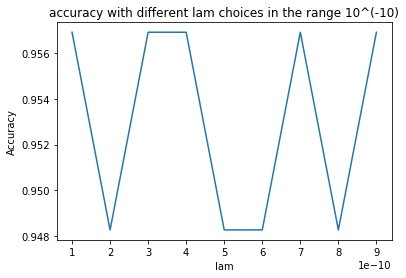

regularization values used - [1e-08, 2e-08, 3.0000000000000004e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 8e-08, 9e-08]
accuracy- ['0.9397', '0.9569', '0.9397', '0.9655', '0.9741', '0.9569', '0.9655', '0.9655', '0.9569']


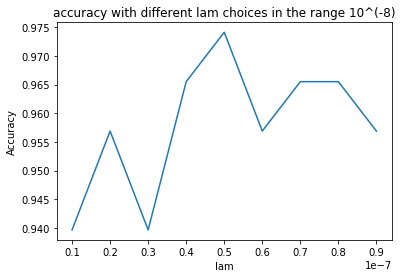

regularization values used - [1e-07, 2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07]
accuracy- ['0.9655', '0.9569', '0.9483', '0.9569', '0.9569', '0.9569', '0.9655', '0.9569', '0.9655']


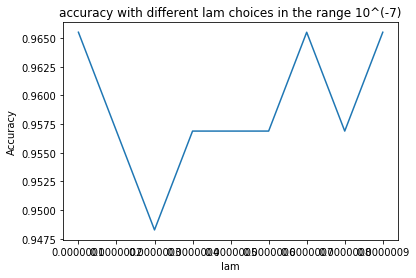

regularization values used - [1e-06, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06]
accuracy- ['0.9569', '0.9483', '0.9569', '0.9569', '0.9569', '0.9741', '0.9569', '0.9655', '0.9655']


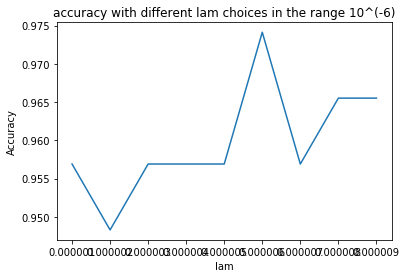

regularization values used - [1e-05, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05]
accuracy- ['0.9397', '0.9483', '0.9569', '0.9483', '0.9741', '0.9569', '0.9655', '0.9569', '0.9483']


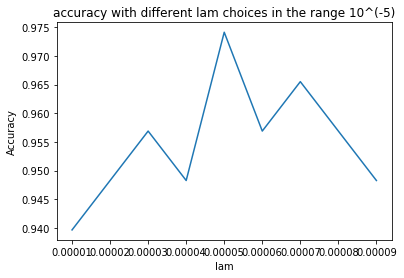

regularization values used - [0.0001, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001]
accuracy- ['0.9655', '0.9655', '0.9483', '0.9655', '0.9655', '0.9483', '0.9569', '0.9569', '0.9483']


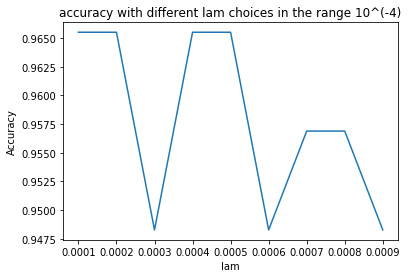

regularization values used - [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001]
accuracy- ['0.9569', '0.9483', '0.9569', '0.9569', '0.9569', '0.9483', '0.9483', '0.9397', '0.9483']


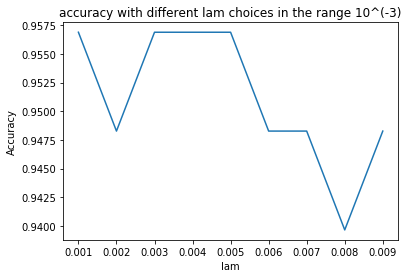

regularization values used - [0, 0.01, 0.1, 0.2, 0.4, 1, 2, 10]
accuracy- ['0.9397', '0.9052', '0.8879', '0.7931', '0.7931', '0.6466', '0.5690', '0.5862']


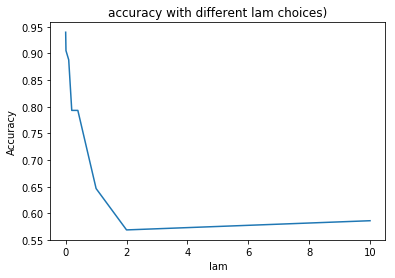

'\nBased on the graph, the value of regularization that gives the highest accuracy lies\nin the window [1 * 10^(-3), 9*10^(-3)]. This consistently show good performance. Based on the former observations\nand the graph below, My choice would be be 6 * 10(-3), although other values of lamda show equally good performance.\nThe performance reduces as the value of lambda increases from 10^(-2) to greater values\nas can be seen from the last graph.\n'

In [70]:
from collections import defaultdict
lam_powers = [-10, -8, -7, -6, -5, -4, -3]

epoch = 3
# Assuming that NLL converges at 3000.
iteration_to_see = 3000
train_set_len = len(train_set)

accuracy = defaultdict(list)
for choice in lam_powers:
    lam_choices = []
    for i in range(1, 10):
        lam_curr = i * pow(10, choice)
        lam_choices.append(lam_curr)
        lr = LogReg(train_set, test_set, lam=lam_curr, eta=0.1)
        lr.train(num_epochs=epoch, report_step=iteration_to_see)
        accuracy[choice].append(np.average(lr.test_acc[1:]))

    print('regularization values used -', lam_choices)
    print('accuracy-', ["{0:.4f}".format(a) for a in accuracy[choice]])
    plt.title('accuracy with different lam choices in the range 10^({})'.format(choice))
    plt.plot(lam_choices, accuracy[choice])
    plt.xlabel('lam')
    plt.ylabel('Accuracy')
    plt.show()

lam_choice = [0, 0.01, 0.1, 0.2, 0.4, 1, 2, 10]
accuracy = []
for choice in lam_choice:
    lr = LogReg(train_set, test_set, lam=choice, eta=0.1)
    lr.train(num_epochs=epoch, report_step=iteration_to_see)
    accuracy.append(np.average(lr.test_acc[1:]))

print('regularization values used -', lam_choice)
print('accuracy-', ["{0:.4f}".format(a) for a in accuracy])
plt.title('accuracy with different lam choices)')
plt.plot(lam_choice, accuracy)
plt.xlabel('lam')
plt.ylabel('Accuracy')
plt.show()
    

"""
Based on the graph, the value of regularization that gives the highest accuracy lies
in the window [4 * 10^(-6), 9*10^(-6)]. These consistently show good performance. Based on the former observations
and the graph below, My choice would be be 6 * 10(-6).
The performance reduces as the value of lambda increases from 10^(-2) to greater values
as can be seen from the last graph.
"""



    
    

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

{8: 4243, 9: 1966, 10: 1789, 11: 2092, 12: 2791, 13: 2002, 14: 3973, 15: 2587, 16: 3010, 17: 4630}


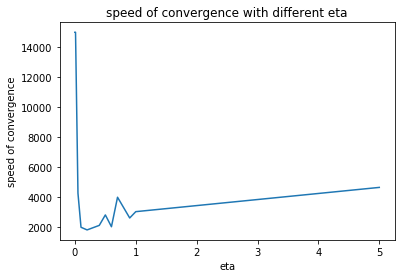

'\n'

In [80]:
from collections import defaultdict
iteration = 0
#num_epochs = 4 #for test
num_epochs = 6 #for train
report_step = 3
number_of_nll_values_compared = 3

eta_choices = [0, 0.000001, 0.000005, 0.00001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 5]

# eta_choices = [0.0001, 0.1]
threshold = 0.8


has_converged = False
eta_i = {}

for idx, eta in enumerate(eta_choices):
        lr = LogReg(train_set, test_set, lam=0.000006, eta=eta)
        has_converged = False
        iteration = 0
#         # Perform an epoch 
        for pp in range(num_epochs):
            np.random.shuffle(lr.train_set)
            # loop over each training example
           
            for ex in lr.train_set:
                # perform SGD update of weights 
                lr.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    #test_nll, test_acc = lr.compute_progress(lr.test_set)
                    train_nll, train_acc = lr.compute_progress(lr.train_set)
#                     print(train_nll)
                    lr.test_nll.append(train_nll)
                    
                    # if last few values {number_of_nll_values_compared} of
                    # nlls differ only by the threshold,
                    # then convergence has reached.
                    if len(lr.test_nll) >= number_of_nll_values_compared:
                        nlls = lr.test_nll[-number_of_nll_values_compared:]
                        if all(abs(nlls[i] - nlls[i+1]) < threshold and nlls[i] < 30 for i in range(0, len(nlls)-1)):
                            eta_i[idx] = iteration
                            has_converged = True
                            break

                iteration += 1
            if has_converged:
                break

print(eta_i)

for idx, eta in enumerate(eta_choices):
    if idx not in eta_i:
        eta_i[idx] = 15000

plt.title('speed of convergence with different eta')
plt.plot(eta_choices, [eta_i[i] for i in range(len(eta_choices))])
plt.xlabel('eta')
plt.ylabel('speed of convergence')
plt.show()


"""
According to the plot below the, learning rate = 0.2 gives the fastest convergence. The study was done
by running 6 epochs. Speed of convergence is defined by the number of iterations it takes to
reach convergence. Convergence is reached when, the NLL < 30
and the difference between the last 3 recorded values is less than a particular threshold (0.8).
For values of learning rate, for which no convergence was reached, I've taken the iterations = 15000
(assuming that it would reach convergence on the 15000th iteration.)

It is seen that values 0.1 and 0.2 tend to do well.
"""

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [62]:
train_set_len = len(train_set)
lr = LogReg(train_set, test_set, lam=0.006, eta=0.1)
lr.train(num_epochs=8, report_step=train_set_len)
sorted_indices = np.argsort(lr.w)
motorcycle_indices = sorted_indices[-10:]
motorcycle_words = [vocab[i] for i in reversed(motorcycle_indices)]
automobile_indices = sorted_indices[:10]
automobile_words = [vocab[i] for i in automobile_indices]
print('top 10 words(best predictors) in dec order for motorcycle - ', motorcycle_words)
print('top 10 words(best predictors)  in dec order for automobile - ', automobile_words)

"""
 The above analysis has been made on weights by sorting them in increasing order.
 For automobile, the smallest weights (maybe higher negative weights) are the best predictors 
 since this shows that the features are more inclined towards the automobile class
 (and not inclined towards the motorcycle class)
 For motorcycle, the largest weights are taken (positive with greater magnitude) since,
 these are strong predictors of class with label 1 which is the motorcycle class.
"""

top 10 words(best predictors) in dec order for motorcycle -  ['bike', 'dod', 'bikes', 'ride', 'riding', 'battery', 'rider', 'frame', 'state', 'ge']
top 10 words(best predictors)  in dec order for automobile -  ['car', 'cars', 'pocket', 'keys', 'BIAS_CONSTANT', 'pockets', 'speed', 'toyota', 'women', 'andrew']


**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [15]:
len_indices = len(sorted_indices)
int(len_indices/2)+5
worst_pred_indices = sorted_indices[int(len_indices/2)-5: int(len_indices/2)+5]
print('10 words that are worst predictors for a class are', [vocab[i] for i in worst_pred_indices])

"""
    the weights are sorted in increasing order of weights. Worst predictors of a class would be 
    the features that predict both classes equally i.e. they are not inclined towards any particular class.
    These would be the weights right in the middle as they would be the least indicative of any class out of
    all the other weights.
"""

10 words that are worst predictors for a class are ['goodyear', 'attract', '1960s', 'inner', 'orleans', 'rebel', 'eagles', 'fold', 'agreement', 'approved']
